In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#importing dataset
Xtrain = np.array(pd.read_csv('dataset/Xtrain.csv',sep=' ',header=None))
Xtest = np.array(pd.read_csv('dataset/Xtest.csv',sep=' ',header=None))
Ytrain_old = np.array(pd.read_csv('dataset/Ytrain.csv',header=None))
Ytrain = Ytrain_old.ravel()
Xtrain.shape

(3000, 784)

### Analysis
##### 3000 training sets and 3000 rows of test examples are there with 784 columns. Out of these 611 samples have positive value (+1) and 2389 samples have negative value (-1). Below is a snippet demonstrating it.

In [90]:
#printing length of training and test data
print('Length of Xtrain: ' ,len(Xtrain))
print('Length of Ytrain: ' ,len(Ytrain))
print('Length of Xtest: ' ,len(Xtest))

#printing count of labels
unique, counts = np.unique(Ytrain, return_counts=True)
d = dict(zip(unique, counts))
for i,j in d.items():
    print('Number of ',i,' labels: ',j)

Length of Xtrain:  3000
Length of Ytrain:  3000
Length of Xtest:  3000
Number of  -1  labels:  2389
Number of  1  labels:  611


#### Plotting random samples of training and test set

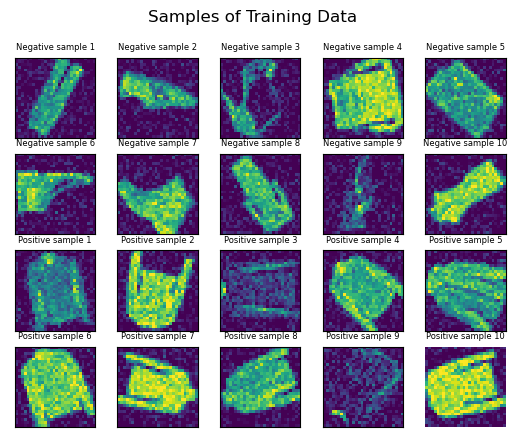

In [91]:
import matplotlib.pyplot as plt
import random

# To get random samples for each unique label in Ytrain 
def sampling(X, y, n):
    unique_ys = np.unique(y, axis=0)
    Xfeatures = []
    Ylabels =[]
    for unique_y in unique_ys:
        indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(indices, n, replace=False)
        Xfeatures.append(X[random_samples])
        Ylabels.append(y[random_samples])
    return np.concatenate(Xfeatures),np.concatenate(Ylabels)

Xfeatures, Ylabels = sampling(Xtrain,Ytrain, 10)
fig, axs = plt.subplots(4, 5)
axs = axs.flatten()
for i in range(0,len(Xfeatures)):
    fig.suptitle('Samples of Training Data', fontsize=12)
    axs[i].matshow(Xfeatures[i].reshape(28,28))
    plt.axis('off')
    class_type = 'Negative' if i<=9 else 'Positive'
    counter = str(i+1) if i<=9 else str((i-9))
    axs[i].set_title(class_type +' sample ' +counter, fontsize=6)
    axs[i].set_xticks([]);axs[i].set_yticks([])

### Plotting random samples of Test data

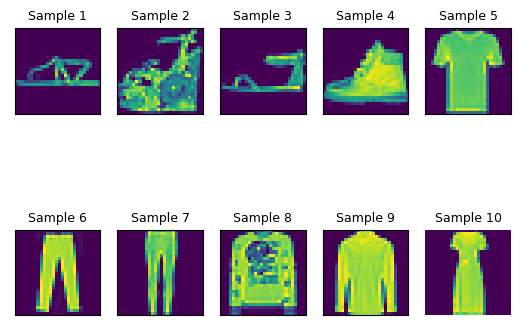

In [92]:

idx = list(range(len(Xtest)))
random.shuffle(idx) #data shuffle for randomising test samples
Xtt = Xtest[idx,:]
fig, axs = plt.subplots(2, 5)
axs = axs.flatten()
for i in range(0,10):
    axs[i].matshow(Xtt[i].reshape(28,28))
    plt.axis('off')
    axs[i].set_title('Sample ' +str(i+1), fontsize=9)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # )

##### The data set has class imbalance issue. The number of samples for negative class is way too higher than the number of positive class samples.

### Analysis
##### Due to class imbalance, the classifier could tend to be more biased towards the majority class, affecting the minority class. Hence the classifier may not generalize the characteristics of the data, leading to overfitting of the training data. AUC-PR is a better performance metric here considering the dataset is severely imbalanced, especially when the number of positive examples(611) is much smaller than the number of negative examples(2389).

### Observations on Random Classifier (to learn to differentiate from our classifiers)
#### Random classifier
##### The accuracy of a random classifier is given by 1/k where k is the number of classes. Since we have 2 classes(1 and -1) in our dataset, the accuracy is around ~50%.
##### Say, x is a fraction of positive samples, and (1-x) is a fraction of negative samples. Let p be the probability with which the random classifier assigns positive class and (1-p) be the probability of assigning negative class. Then,
##### TP = px, FP = p(1-x), FN = (1-p)x, TN = (1-p)(1-x)
##### TPR = TP/TP+FN = px/px+(1-p)x = p
##### FPR = FP/FP+TN = p(1-x)/p(1-x)+(1-p)(1-x) = p
##### The above equation means that TPR = FPR. Hence, it is not dependant on the x value. Due to this, the accuracy is always around 50%.
##### Below is a random classifier which assigns random values of approximately around ~50% split of positive and negative labels.

In [93]:
from numpy.random import randn,randint
from sklearn.metrics import accuracy_score

# random classifier that predicts random classes
Ypred = 2*randint(0,2,len(Xtt))-1
ac= accuracy_score(Ytrain,Ypred)
print('The accuracy is ',ac)

The accuracy is  0.49566666666666664


##### The AUC-ROC of the above random classifier is a straight line along the diagonal. Since the area under the curve is always going to be 0.5 the curve looks like a straight line along the diagonal.
##### Unlike the ROC curve which gives a straight line along the diagonal, the AUC-PR curve is different depending on the number of negative examples in the dataset. Since there is a lot of negative samples, it is expected that the PR score is lower too.
##### Below is a snippet with Dummy classifier to demonstrate this.

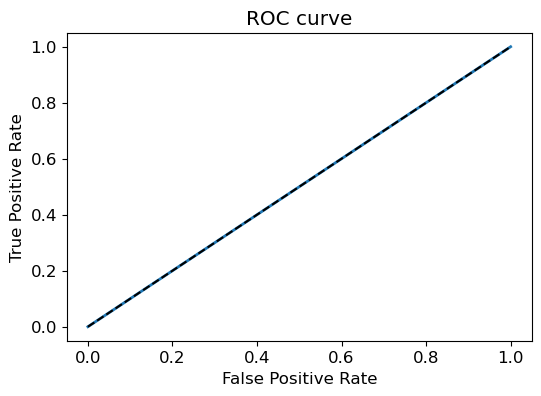

AUC ROC score is:  0.5


In [94]:
from sklearn.metrics import *
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, Ytrain)
Ypred = dummy_clf.predict(Xtrain)
yscore = dummy_clf.predict_proba(Ypred)[:,1]
fpr, tpr, thresholds = roc_curve(Ytrain, yscore)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print('AUC ROC score is: ', roc_auc_score(Ytrain, Ypred))

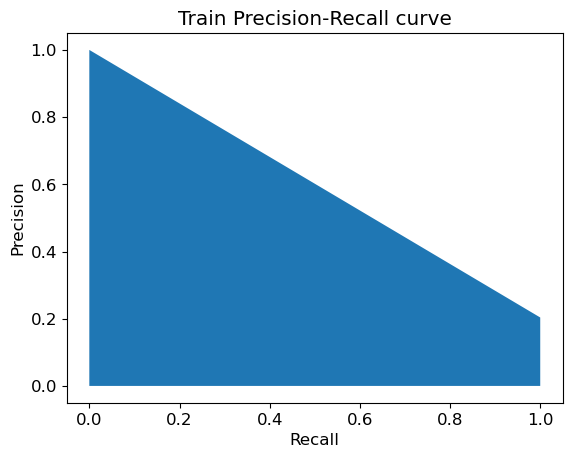

AUC PR score is:  0.20366666666666666


In [95]:
precision, recall, thresholds = precision_recall_curve(Ytrain, yscore)
aucpr = average_precision_score(Ytrain, yscore)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")
plt.show()
print('AUC PR score is: ', aucpr)

##### Performing 5-fold [stratified cross-validation](https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) over the training dataset using the k = 1 nearest neighbour classifier


In [96]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = 5
# functions for calculating and plotting ROC and PR curves
def scoreROC(y,z,flag):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    score = roc_auc_score(y, z)
    if flag:
        plt.figure(figsize=(6, 3))
        plt.plot(fpr,tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid()
        plt.title('ROC '+' AUC: '+str(roc_auc))
    return [score,fpr,tpr]
def scorePRC(y,z,flag):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    if(flag):
        plt.figure(figsize=(6, 3))
        plt.plot(R,P)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid()
        plt.title('PRC '+' AUC: '+str(pr_auc))
    return [pr_auc,R,P]

# print in table format
def show_table(accuracy_scores,balanced_accuracy,roc_scores,pr_scores,mean_values, stdv):
    data = np.column_stack((accuracy_scores,balanced_accuracy,roc_scores,pr_scores))
    data = np.vstack((data, mean_values, stdv))
    return pd.DataFrame(data, ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5','Average', 'Standard Deviation'], ['Accuracy','Balanced Accuracy','ROC', 'PR'])


In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import *
from statistics import mean, stdev
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def cross_validation_fn(clf,Xtrain,Ytrain,flag, flag_yscores, showplots):
    
    # initializing folds and variables to capture different metrics
    skf = StratifiedKFold(n_splits=kfold)
    accuracy_scores = []
    balanced_accuracy = []
    roc_scores = []
    pr_scores = []
    stdv = []
    mean_values = []
    counter = 0
    for train_index, test_index in skf.split(Xtrain, Ytrain):
        x_train_fold, y_train_fold = Xtrain[train_index], Ytrain[train_index]
        x_test_fold, y_test_fold = Xtrain[test_index], Ytrain[test_index]
        clf.fit(x_train_fold, y_train_fold)
        Ypred = clf.predict(x_test_fold)
        # changing the yscore function according to classifiers
        if flag_yscores :
            y_scores = clf.decision_function(x_test_fold)
        else :
            y_scores = clf.predict_proba(x_test_fold)[:, 1]
        roc_scores.append(scoreROC(y_test_fold,y_scores,flag))
        pr_scores.append(scorePRC(y_test_fold,y_scores,flag))
        accuracy_scores.append(clf.score(x_test_fold, y_test_fold))
        balanced_accuracy.append(balanced_accuracy_score(y_test_fold,Ypred))
        # plotting roc and pr curves for one fold
        if(counter == 4 and showplots):
            scoreROC(y_test_fold,y_scores,True)
            scorePRC(y_test_fold,y_scores,True)
        counter+=1
    names = [accuracy_scores,balanced_accuracy,np.array(roc_scores)[:,0],np.array(pr_scores)[:,0]]
    for i in range(0,4):
        stdv.append(stdev(names[i]))
        mean_values.append(mean(names[i]))
    return accuracy_scores,balanced_accuracy,np.array(roc_scores),np.array(pr_scores),mean_values, stdv
    

##### Populating prediction accuracy, AUC-ROC and AUC-PR for each fold using this classifier

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.873333,0.801461,0.893357,0.645187
Fold 2,0.875,0.817769,0.901742,0.658463
Fold 3,0.876667,0.791344,0.882657,0.651272
Fold 4,0.876667,0.797448,0.883531,0.652129
Fold 5,0.86,0.800327,0.882872,0.632343
Average,0.872333,0.80167,0.888832,0.647879
Standard Deviation,0.007032,0.009817,0.008499,0.009877


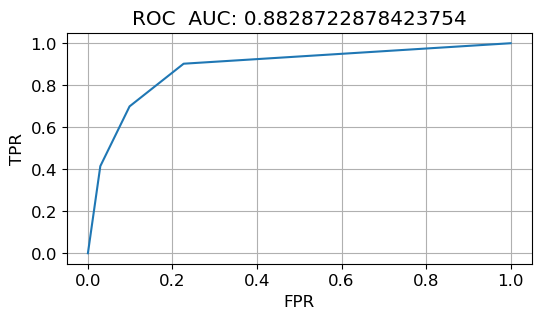

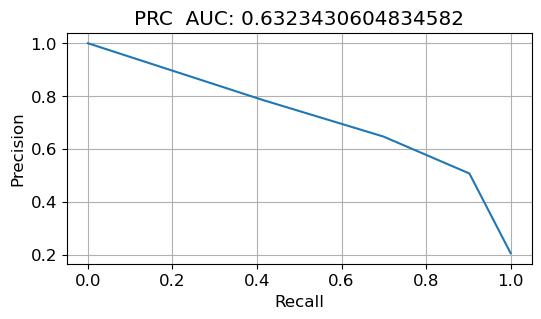

In [98]:
# KNN classifier    
knn = KNeighborsClassifier(n_neighbors = 3)
acc_knn,balanced_knn,roc_knn,pr_knn,mean_knn, stdv_knn = cross_validation_fn(knn,Xtrain,Ytrain,False, False, True)
show_table(acc_knn,balanced_knn,roc_knn[:,0],pr_knn[:,0],mean_knn, stdv_knn)


##### ROC and PR curve for one fold are shown above.
##### Since we have class imbalance, the ROC curve region between 0 to 0.2 along X-axis is to be focused. Here the ROC curve has an average score of around 90. But, the same space in PR curve shows the ability of the model to identify high number of true positives yet it has got some false positives too. If identifying the positive class is more important than avoiding false positives, then this PR curve could be useful in this case.

### Preprocessing
##### Normalizing

In [99]:
X_normalized = preprocessing.normalize(Xtrain)

##### Standard Scaling

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.868333,0.862422,0.913823,0.688916
Fold 2,0.9,0.885349,0.929762,0.69566
Fold 3,0.873333,0.86556,0.927636,0.695181
Fold 4,0.881667,0.861633,0.91907,0.676457
Fold 5,0.861667,0.861712,0.912393,0.657018
Average,0.877,0.867335,0.920537,0.682646
Standard Deviation,0.014786,0.010197,0.007891,0.016286


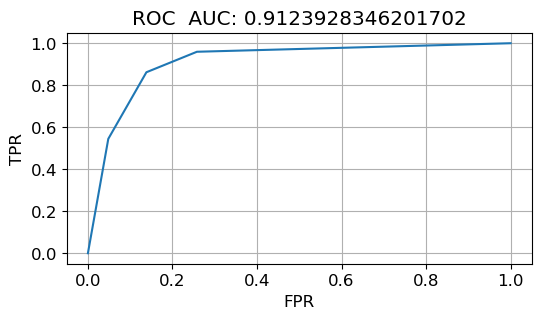

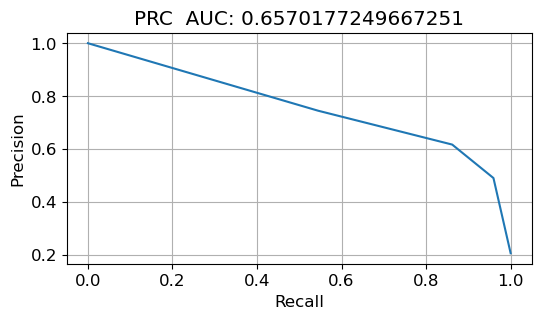

In [100]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_normalized)
# X_train.mean(axis=0)
# X_train.std(axis=0)
# scaler.mean_
accuracy_scores,balanced_accuracy,roc_scores,pr_scores,mean_values, stdv = cross_validation_fn(knn,X_train,Ytrain,False, False,True)
show_table(accuracy_scores,balanced_accuracy,roc_scores[:,0],pr_scores[:,0],mean_values, stdv)

##### MinMax Scaling

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.866667,0.855271,0.911568,0.681167
Fold 2,0.893333,0.862851,0.932917,0.730535
Fold 3,0.883333,0.859627,0.924755,0.716246
Fold 4,0.881667,0.849424,0.921917,0.700652
Fold 5,0.87,0.860919,0.91581,0.652651
Average,0.879,0.857618,0.921393,0.69625
Standard Deviation,0.010775,0.005361,0.008247,0.030508


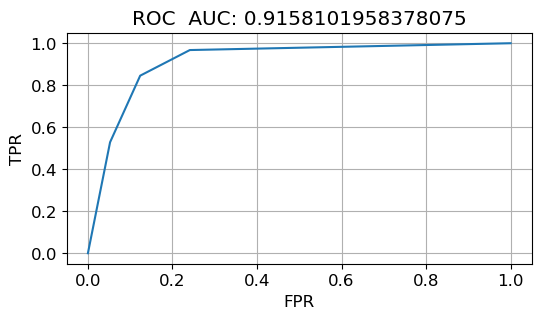

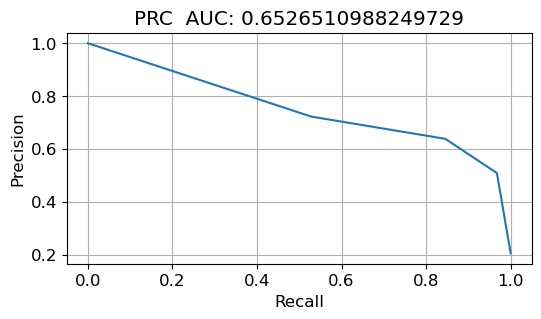

In [101]:

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_normalized)
accuracy_scores,balanced_accuracy,roc_scores,pr_scores,mean_values, stdv = cross_validation_fn(knn,X_train,Ytrain,False, False, True)
show_table(accuracy_scores,balanced_accuracy,roc_scores[:,0],pr_scores[:,0],mean_values, stdv)

##### The standard scalar and minmax scaler have almost similar effect on the model. The variance in minmax scaler is captured a bit more higher than the standard scalar. Whereas, the standard scalar has a slight higher PR score. Although there is slight differences, the overall accuracy or other metrics do not have any significant changes. This simply means that the features are already on a similar scale.

##### As our dataset has class imbalance, accuracy and roc alone cannot be sufficient to arive at a conclusion. PR curve score is also needed to be observed for the classifiers considered. Overall, the Kernelized SVM performs better in all of the metrics considered like accuracy, roc scores and pr scores in a 5 fold cross validation with tuned hyper parameters.
##### Below are the blocks of code to show the metrics and graphs used to be able to arrive at a conclusion.

In [102]:
from sklearn.linear_model import Perceptron
pcp = Perceptron(alpha=0.001) #tuned param
perceptron_params = {'alpha': [0.001, 0.01, 0.1, 1]}
acc_pcp,ba_pcp,roc_pcp,pr_pcp,mean_pcp, stdv_pcp = cross_validation_fn(pcp,Xtrain,Ytrain,False,True,False)
show_table(acc_pcp,ba_pcp,roc_pcp[:,0],pr_pcp[:,0],mean_pcp, stdv_pcp)

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.801667,0.585551,0.754476,0.461105
Fold 2,0.841667,0.726644,0.84452,0.643864
Fold 3,0.601667,0.713372,0.862028,0.639002
Fold 4,0.828333,0.641968,0.768451,0.524339
Fold 5,0.728333,0.744669,0.819536,0.573206
Average,0.760333,0.682441,0.809802,0.568303
Standard Deviation,0.098928,0.066725,0.0469,0.077711


In [103]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB(var_smoothing=1e-10)
acc_nb,balanced_nb,roc_nb,pr_nb,mean_nb, stdv_nb = cross_validation_fn(nb,Xtrain,Ytrain,False,False,False)
show_table(acc_nb,balanced_nb,roc_nb[:,0],pr_nb[:,0],mean_nb, stdv_nb)

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.761667,0.755796,0.798237,0.441175
Fold 2,0.786667,0.792853,0.827612,0.481243
Fold 3,0.743333,0.735133,0.763495,0.414479
Fold 4,0.743333,0.729028,0.761858,0.404053
Fold 5,0.721667,0.719359,0.74882,0.395141
Average,0.751333,0.746434,0.780004,0.427218
Standard Deviation,0.024307,0.029181,0.0323,0.03479


In [104]:
from sklearn.svm import SVC
lsvm = SVC(kernel='linear', C = 0.01)
acc_lsvm,balanced_lsvm,roc_lsvm,pr_lsvm,mean_lsvm, stdv_lsvm = cross_validation_fn(lsvm,Xtrain,Ytrain,False,True,False)
show_table(acc_lsvm,balanced_lsvm,roc_lsvm[:,0],pr_lsvm[:,0],mean_lsvm, stdv_lsvm )

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.768333,0.686724,0.752366,0.457766
Fold 2,0.798333,0.711657,0.79642,0.555156
Fold 3,0.781667,0.698145,0.756499,0.456274
Fold 4,0.78,0.681837,0.749897,0.461112
Fold 5,0.776667,0.678529,0.763631,0.499826
Average,0.781,0.691378,0.763763,0.486027
Standard Deviation,0.010967,0.013554,0.018983,0.042644


In [105]:
# kernalized SVM
ksvm = SVC(C = 1, kernel = 'poly', degree = 2, coef0 = 1.0)
acc_ksvm,balanced_ksvm,roc_ksvm,pr_ksvm,mean_ksvm, stdv_ksvm = cross_validation_fn(ksvm,Xtrain,Ytrain,False,True,False)
show_table(acc_ksvm,balanced_ksvm,roc_ksvm[:,0],pr_ksvm[:,0],mean_ksvm, stdv_ksvm)
 

,Accuracy,Balanced Accuracy,ROC,PR
Fold 1,0.873333,0.789252,0.869984,0.634745
Fold 2,0.89,0.78445,0.940171,0.819706
Fold 3,0.873333,0.755676,0.912014,0.742872
Fold 4,0.865,0.750446,0.890613,0.714566
Fold 5,0.868333,0.7754,0.903973,0.699817
Average,0.874,0.771045,0.903351,0.722341
Standard Deviation,0.009618,0.017253,0.026013,0.067347


##### Using 5-fold stratified cross-validation over training data to choose an optimal classifier between: k-nearest neighbour, Perceptron,Naïve Bayes Classifier, Logistic regression, Linear SVM and Kernelized SVM

In [106]:
def classifiers_comparision(v1,v2,v3,v4,c1,c2,c3,c4):
    row1 = np.column_stack((v1,v2,v3,v4))
    row2 = np.column_stack((c1,c2,c3,c4))
    data = np.vstack((row1,row2))
    return pd.DataFrame(data,['Avg. Accuracy', 'Avg. Balanced Accuracy', 'Avg. ROC', 'Avg. PR','Std. Accuracy', 'Std. Balanced Accuracy', 'Std. ROC', 'Std. PR'], 
                        ['Perceptron','Naive Bayes','Linear SVM', 'Kernelized SVM'])
classifiers_comparision(mean_pcp, mean_nb ,mean_lsvm ,mean_ksvm,stdv_pcp ,stdv_nb ,stdv_lsvm ,stdv_ksvm)


,Perceptron,Naive Bayes,Linear SVM,Kernelized SVM
Avg. Accuracy,0.760333,0.751333,0.781000,0.874000
Avg. Balanced Accuracy,0.682441,0.746434,0.691378,0.771045
Avg. ROC,0.809802,0.780004,0.763763,0.903351
Avg. PR,0.568303,0.427218,0.486027,0.722341
Std. Accuracy,0.098928,0.024307,0.010967,0.009618
Std. Balanced Accuracy,0.066725,0.029181,0.013554,0.017253
Std. ROC,0.046900,0.032300,0.018983,0.026013
Std. PR,0.077711,0.034790,0.042644,0.067347


##### Plotting ROC curves and PR curves

In [107]:

def plotROC_all(roc1,roc2,roc3,roc4):
    # fpr,tpr,tt = roc_curve(y, z)
    plt.figure(figsize=(6, 3))
    plt.plot(roc1[0,1],roc1[0,2], color='blue')
    plt.plot(roc2[0,1],roc2[0,2], color='green')
    plt.plot(roc3[0,1],roc3[0,2], color='red')
    plt.plot(roc4[0,1],roc4[0,2], color='orange')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.title('ROC '+' AUC')
def plotPR_all(pr1,pr2,pr3,pr4):
    plt.figure(figsize=(6, 3))
    plt.plot(pr1[4,1],pr1[4,2], color='blue')
    plt.plot(pr2[4,1],pr2[4,2], color='green')
    plt.plot(pr3[4,1],pr3[4,2], color='red')
    plt.plot(pr4[4,1],pr4[4,2], color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.title('PRC '+' AUC')

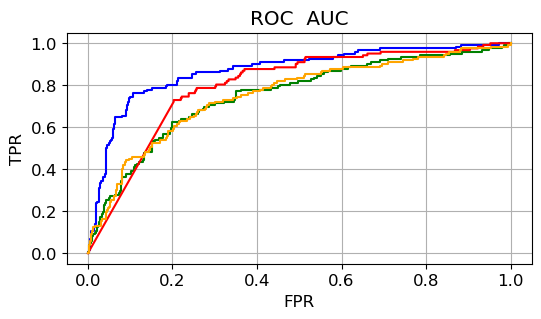

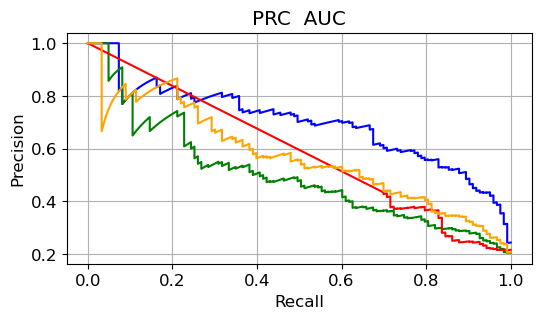

In [108]:
plotROC_all(roc_ksvm,roc_lsvm,roc_nb,roc_pcp)
plotPR_all(pr_ksvm, pr_lsvm, pr_nb, pr_pcp)

##### As we have class imbalance in our dataset, the crucial part to observe in the ROC curve is the region between 0.0 and 0.2 along X-axis. Here the blue line indicates Kernelized SVM classifier. Among the classifiers considered, this has a better ROC curve than other and hence it is expected that this will lead the others in the PR curve too.
##### Observing the PR curves graph, the blue line is better than the rest as expected. The area under the curve is also higher than the other classifiers. Say, in the above graphs, TPR at 0.6 in ROC curve gives around 0.1 FPR. The same region of TPR in PR curve gives a precision of around 0.7. 

##### Dimensionality Reduction of training data (PCA to 2)


In [109]:
from sklearn.decomposition import PCA #import PCA

def reduce_dimension(train,test,n):
    pca = PCA(n_components = n)
    Xtrain_temp = pca.fit_transform(train)
    # print('shape ',Xtrain_temp.shape)
    Xtest_temp = pca.transform(test)
    return Xtrain_temp,Xtest_temp,pca

def plotPCA(x,y, flag):
    pca_df = pd.DataFrame({'PC1': x[:, 0], 'PC2': x[:, 1], 'target': y})
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target')


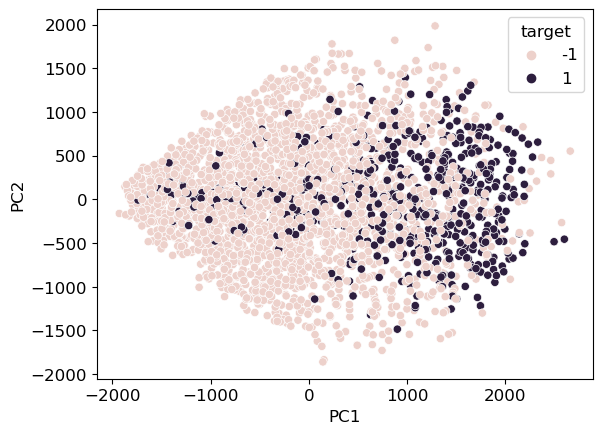

In [110]:
import seaborn as sns

Xtrain_temp, Xtest_temp,pca = reduce_dimension(Xtrain, Xtest, 2)
plotPCA(Xtrain_temp,Ytrain, True)

##### Based on the plot, the overlapping data of positive and negative classes implies that the classes are not well separated in reduced space. This means that the two principal components are not enough to capture the difference between the classes. This could make it difficult to separate classes and hence we need to find the right number of components for performing PCA to capture more information.

##### Plotting training data and test data

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

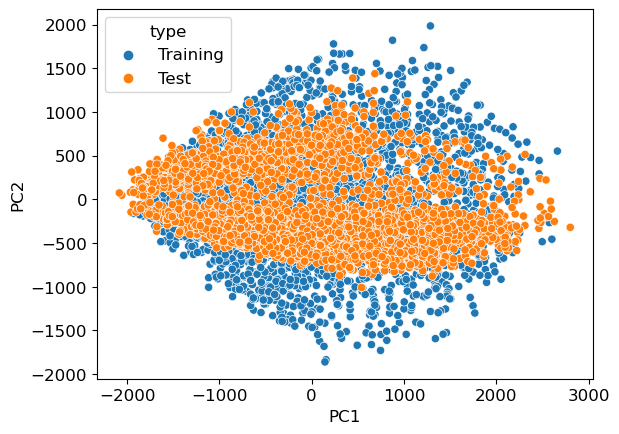

In [111]:
train_df = pd.DataFrame(Xtrain_temp, columns=['PC1', 'PC2'])
test_df = pd.DataFrame(Xtest_temp, columns=['PC1', 'PC2'])
train_df['type'] = 'Training'
test_df['type'] = 'Test'
df = pd.concat([train_df, test_df], axis=0)
sns.scatterplot(data=df, x='PC1', y='PC2', hue='type')


##### From the above plot, it can be seen that the test data overlaps the training data points of both the classes. Also, we could see the overlap of positive and negative samples in the training in the above scatter plot. With these observations, it can be stated that the reduced feature space obtained from the 2 principal components using PCA is not sufficient and due to this, the model might suffer to identify the classes correctly in the test data and might be biased towards the negative class.

##### Plotting scree graph
##### It can be seen from the graph that approximately around 300 components captures 95% variance in the training set.

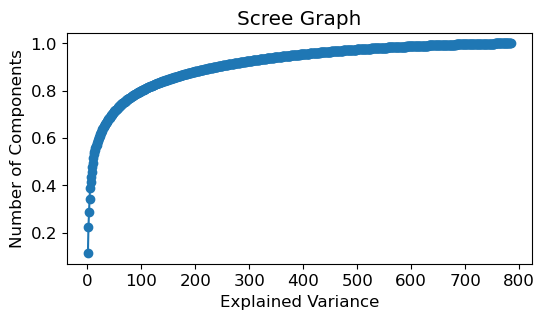

The number of components that explains 95% variance is  384


In [116]:
X_normalized = preprocessing.normalize(Xtrain)
Xtrain_temp, Xtest_temp,pca = reduce_dimension(X_normalized, Xtest, 784)

variance = pca.explained_variance_ratio_
total = np.cumsum(variance)
plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(pca.explained_variance_ratio_))+1,np.cumsum(pca.explained_variance_ratio_),'o-') #plot the scree graph
plt.xlabel('Explained Variance')
plt.ylabel('Number of Components')
plt.title('Scree Graph')
plt.show()

# finding the number of dimensions that explains 95% variance
n_comp = np.argmax(total >= 0.95) + 1
print('The number of components that explains 95% variance is ',str(n_comp))

### Cross-validation performance of a Kernelized SVM classification with PCA

In [113]:
from sklearn.model_selection import train_test_split

Xtrain_temp, Xtest_temp,pca = reduce_dimension(Xtrain, Xtest, 314)

X_train, X_test, y_train, y_test = train_test_split(Xtrain_temp,Ytrain)

ksvm = SVC()

# Tested hyper parameters - 'C': [0.1, 1, 10, 100, 1000], 
# 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid','poly']}
# Found best parameters using grid.best_params_
# Commented out as it takes a lot of time to run the above code

# Proceeding with best params for our purpose
param_grid = {'C': [0.1], 'gamma': [0.0001], 'kernel': ['poly']}
grid = GridSearchCV(ksvm, param_grid)
grid.fit(Xtrain_temp, Ytrain)
print("Cross-validation score: ", grid.best_score_)

# Evaluate the performance of the model on the testing data
Ypred = grid.predict(Xtrain_temp)
accuracy = accuracy_score(Ytrain, Ypred)
print("Accuracy on testing data: ", accuracy)

Cross-validation score:  0.8626666666666667
Accuracy on testing data:  1.0


##### Developing an optimal pipeline for classification based on our analyses above and reporting the result in a single column prediction file containing the prediction score of the corresponding example in Xtest.

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaler', StandardScaler()), # standardize the features
        ('pca', PCA()), # PCA with number of components with 95% variance obtained from 4th section
    ('svm',SVC())]) # support vector machine classifier 

param_grid = {'pca__n_components': [2],'svm__C': [0.1], 'svm__gamma':[0.1],'svm__degree': [2], 'svm__coef0':[1.0],
              'svm__kernel': ['poly']}
grid = GridSearchCV(pipeline,param_grid, cv = 5)
grid.fit(Xtrain, Ytrain)
Ypred = grid.predict(Xtest)
print(Ypred.shape)
pd.DataFrame(Ypred, columns=['Ypred']).to_csv('prediction.csv', index=False)

# unique, counts = np.unique(Ypred, return_counts=True)
# dict(zip(unique, counts))


(3000,)


##### Using the data, we consider an alternate classification problem in which the label of an example is based on whether it is a part of the training set (label = -1) or the test set (label = +1). We then calculate the average and standard deviation of AUC-ROC using 5-fold stratified cross-validation for a classifier that is trained to solve this prediction task.

In [115]:
Y_train= randint(-1,0,len(Xtrain))
Y_test = randint(1,2,len(Xtest))

Y_train

skf = StratifiedKFold(n_splits=5)

#Combine training and test data into a new dataset
x = np.concatenate([(Xtrain),(Xtest)])
# Assigning -1 label for training data and 1 for test data and combining it
y = np.concatenate([-np.ones(len(Xtrain)), np.ones(len(Xtest))])
roc_scores = []
for train_ind, test_ind in skf.split(x, y):
    X_train, X_test = x[train_ind], x[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]

    # Fit classifier on training set
    ksvm.fit(X_train, y_train)

    # Predict probabilities on test set
    y_pred = nb.predict_proba(X_test)[:, 1]
    # Compute AUC-ROC score
    roc_scores.append(roc_auc_score(y_test, y_pred))
    
mean_roc = np.mean(roc_scores)
std_roc = np.std(roc_scores)

print("Mean AUC-ROC: %.4f" % mean_roc)
print("Standard Deviation AUC-ROC: %.4f" % std_roc)

Mean AUC-ROC: 0.4886
Standard Deviation AUC-ROC: 0.0102


##### The ROC score is close to 1 and it states that the classifier performs really well in distinguishing between positive and negative classes. The lower value of standard deviation means that the model's result is consistent across different folds and hence it is generalized.